# Wind Power Forecasting - Task 1
Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.widgets import Button
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load training data
train = pd.read_csv('TrainData.csv', parse_dates=['TIMESTAMP'])
X_train = train[['WS10']].values
y_train = train['POWER'].values

# Load forecast input
weather_forecast = pd.read_csv('WeatherForecastInput.csv', parse_dates=['TIMESTAMP'])
X_test = weather_forecast[['WS10']].values
timestamps_test = weather_forecast['TIMESTAMP']

# Load true values
solution = pd.read_csv('Solution.csv', parse_dates=['TIMESTAMP'])
y_true = solution['POWER'].values

# Load Forecast Template
template = pd.read_csv('ForecastTemplate.csv', parse_dates=['TIMESTAMP'])

## Parameter analysis (Exploratory data analysis)
Main values: 10-meter Wind speed and power generation, the data that was provided did not explicitly explain how they measured it therefore there are some assumptions

- WS10 is total wind speed at 10m calculated from U10 V10 (presumably)
- POWER is the wind power generation
- extra parameters:
    - U10 is wind speed from west to east at 10m above ground
    - V10 is wind speed from south to north at 10m above ground
    - U100 is wind speed from west to east at 100m above ground
    - V100 is wind speed from south to north at 100m above ground
    - WS100 is total wind speed at 100m calculated from U100 V100 (presumably)

,TIMESTAMP,POWER,U10,V10,WS10,U100,V100,WS100
count,16080,16080.000000,16080.000000,16080.000000,16080.000000,16080.000000,16080.000000,16080.000000
mean,2012-12-01 00:30:00,0.431744,0.835555,0.065609,4.204296,1.222104,-0.044612,6.698307
min,2012-01-01 01:00:00,0.000000,-8.092973,-9.970424,0.078144,-11.881494,-16.569645,0.077554
25%,2012-06-16 12:45:00,0.113896,-2.017153,-1.964820,2.695771,-3.163133,-3.375639,4.791792
50%,2012-12-01 00:30:00,0.379385,0.713629,0.329663,3.881318,1.300118,0.544008,6.501877
75%,2013-05-17 12:15:00,0.747897,3.313748,2.126128,5.344101,5.187705,3.611386,8.275765
max,2013-11-01 00:00:00,1.000000,14.019047,8.709613,14.474997,19.678310,12.525632,20.409066
std,NaN,0.336587,3.537281,2.906424,1.996235,5.424995,4.697660,2.850280


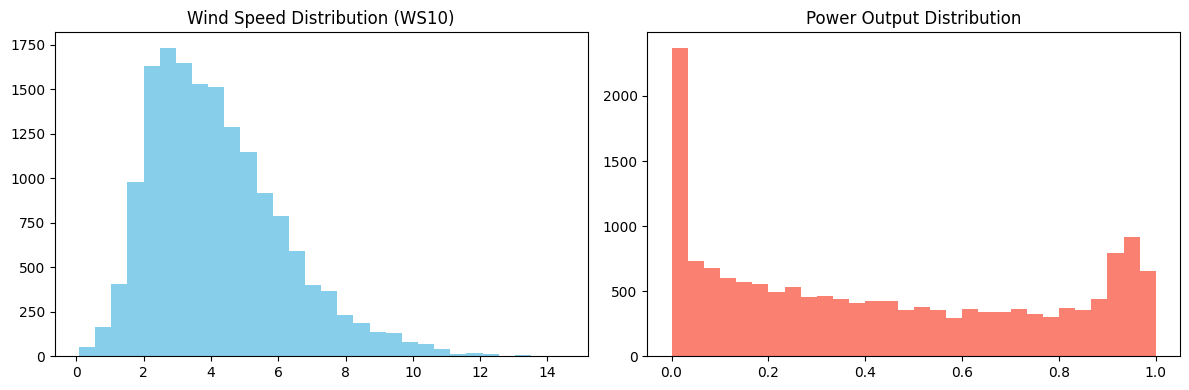

In [3]:
# Display basic statistics
display(train.describe())

# Visualize WS10 and POWER
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train['WS10'], bins=30, color='skyblue')
plt.title('Wind Speed Distribution (WS10)')

plt.subplot(1, 2, 2)
plt.hist(train['POWER'], bins=30, color='salmon')
plt.title('Power Output Distribution')
plt.tight_layout()
plt.show()

An interesting observation on the above plots, is that power output distribution spikes on near 0 power and also increases on near 1. Meaning that most of the power that is measures is either 0 or 1 with some slight variation. 

The wind speed distribution looks fairly normal without any anomalies usually the most of the windspeed measured where about 4 m/s (assumed they used measuring unit m/s the dataset does not say it explicitly )

## Model Training and Evaluation
We train and evaluate 4 models: Linear Regression (LR), KNN, SVR, and Neural Network (NN).
Evaluation metrics include RMSE and SMAPE-based accuracy.

In [4]:
models = {
    'LR': (LinearRegression(), 'ForecastTemplate1-LR.csv'),
    'kNN': (KNeighborsRegressor(n_neighbors=5), 'ForecastTemplate1-kNN.csv'),
    'SVR': (SVR(kernel='rbf', C=100, epsilon=0.1), 'ForecastTemplate1-SVR.csv'),
    'NN': (MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42), 'ForecastTemplate1-NN.csv')
}

predictions = {}
results = []

for name, (model, filename) in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    forecast_df = template.copy()
    forecast_df['FORECAST'] = y_pred
    forecast_df.to_csv(filename, index=False)
    predictions[name] = y_pred

    rmse = sqrt(mean_squared_error(y_true, y_pred))
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-3))
    accuracy = 100 - smape
    results.append((name, rmse, accuracy))

    print(f"{name} RMSE: {rmse:.4f}")
    print(f"{name} Prediction Accuracy (SMAPE): {accuracy:.2f}%\n")

LR RMSE: 0.2164
LR Prediction Accuracy (SMAPE): 33.13%

kNN RMSE: 0.2349
kNN Prediction Accuracy (SMAPE): 31.71%

SVR RMSE: 0.2138
SVR Prediction Accuracy (SMAPE): 33.22%

NN RMSE: 0.2154
NN Prediction Accuracy (SMAPE): 33.66%



In [5]:
result_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'Accuracy (SMAPE %)'])
result_df.sort_values('RMSE')

,Model,RMSE,Accuracy (SMAPE %)
2,SVR,0.213772,33.220081
3,NN,0.215450,33.660909
0,LR,0.216384,33.131001
1,kNN,0.234865,31.710346


Adding R2 (R-squared)
R2 tells us what percentage of variance in the data the model is capturing

In [10]:
from sklearn.metrics import r2_score


for name, (model, _) in models.items():
    r2_train = r2_score(y_train, model.predict(X_train))
    print(f"{name} R² Score on Training Data: {r2_train:.4f}")

print("\nR² Scores for each model:")
for name, y_pred in predictions.items():
    r2 = r2_score(y_true, y_pred)
    print(f"{name} R² Score on Testing Data: {r2:.4f}")

LR R² Score on Training Data: 0.5286
kNN R² Score on Training Data: 0.6543
SVR R² Score on Training Data: 0.5551
NN R² Score on Training Data: 0.5617

R² Scores for each model:
LR R² Score on Testing Data: 0.4542
kNN R² Score on Testing Data: 0.3570
SVR R² Score on Testing Data: 0.4673
NN R² Score on Testing Data: 0.4590


In the above scores (goodness of fit) SVR fits best for the testing data, but it explains less than 0.6 of the variance in the data, meaning that most likely the model and also all the models below it are underfitted. Ideal R2 value is between 0.6 and 0.9 anything above 0.9 would be overfitting. 

## Forecast vs Actual Visualization
Below, we plot the predicted vs actual wind power values for each model for the month of November 2013.

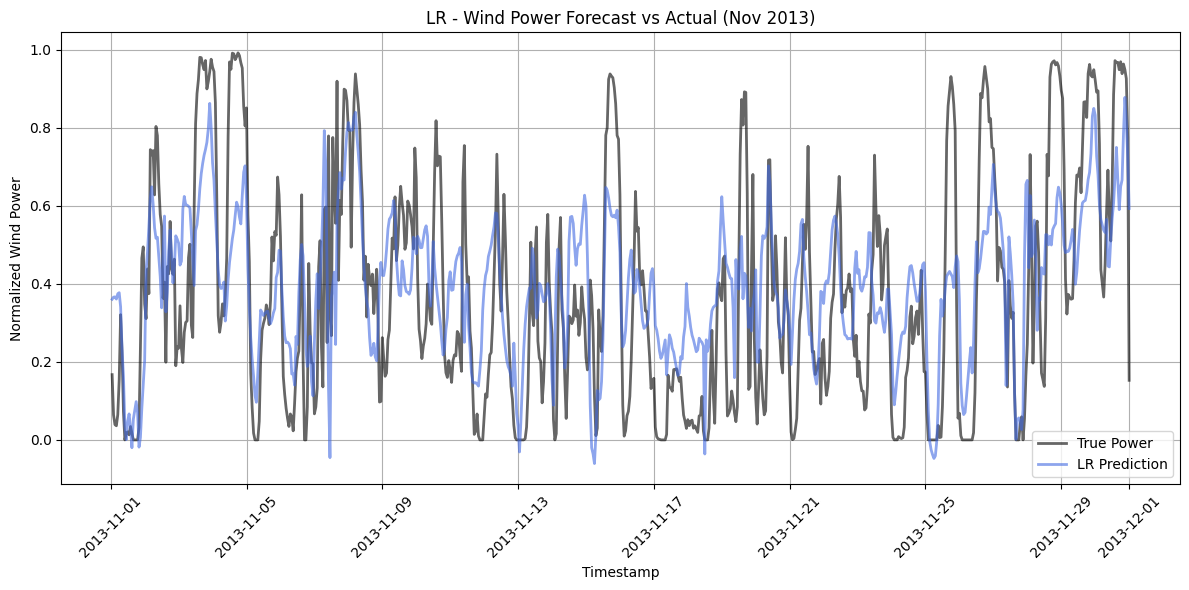

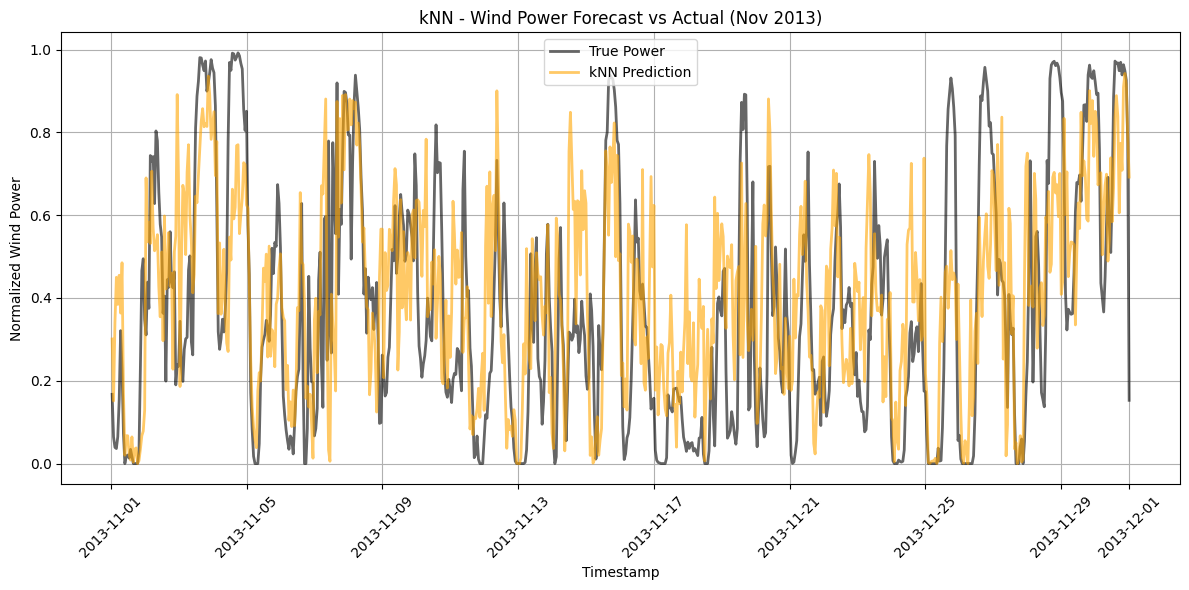

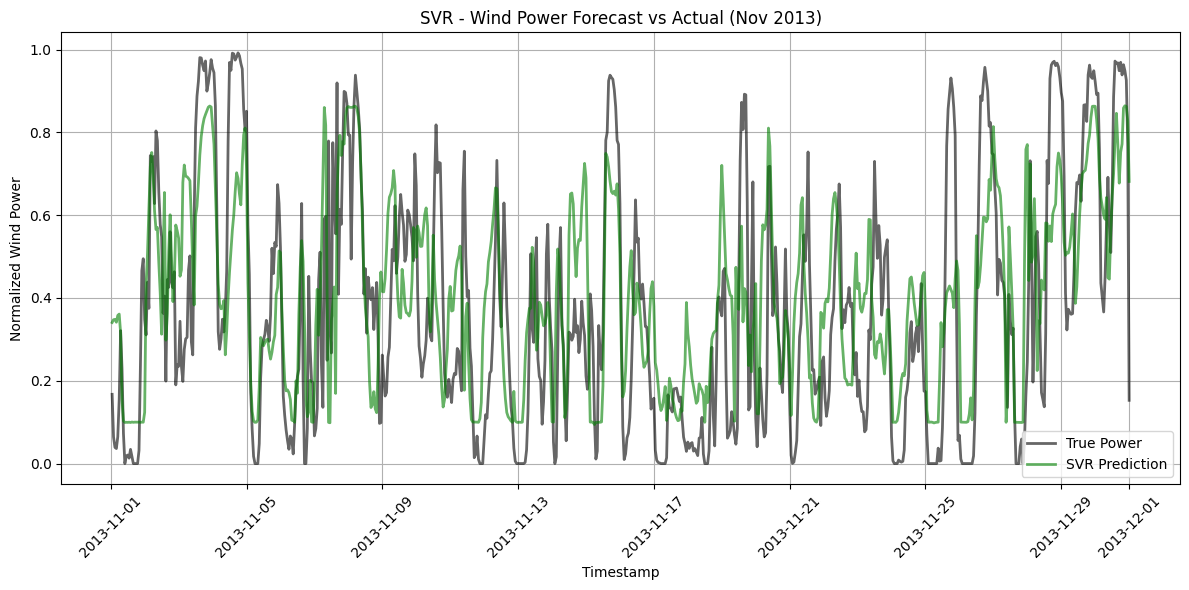

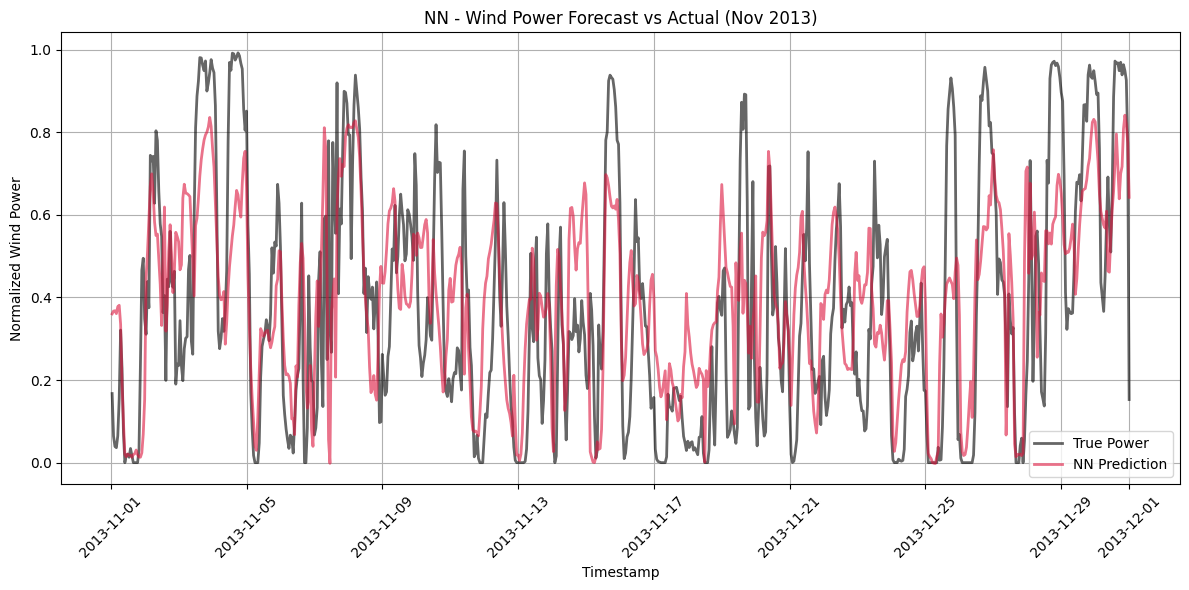

In [7]:
# Define colors for each model
model_colors = {
    'LR': 'royalblue',
    'kNN': 'orange',
    'SVR': 'green',
    'NN': 'crimson'
}

# Individual plots for each model with distinct colors
for name, y_pred in predictions.items():
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot true power
    ax.plot(timestamps_test, y_true, label='True Power', color='black', linewidth=2, alpha=0.6)
    
    # Plot model prediction with specified color
    ax.plot(timestamps_test, y_pred, label=f'{name} Prediction', color=model_colors.get(name, 'blue'), linewidth=2, alpha=0.6)
    
    # Formatting
    ax.set_title(f'{name} - Wind Power Forecast vs Actual (Nov 2013)')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Normalized Wind Power')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()